In [72]:
#Import Librarii Python

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from pysheds.grid import Grid
from pysheds.rfsm import RFSM
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import fiona
import geopandas as gpd
from shapely import geometry, ops
import mplleaflet
import warnings
import skimage
import skimage.transform
import skimage.measure
warnings.filterwarnings('ignore')

%matplotlib inline

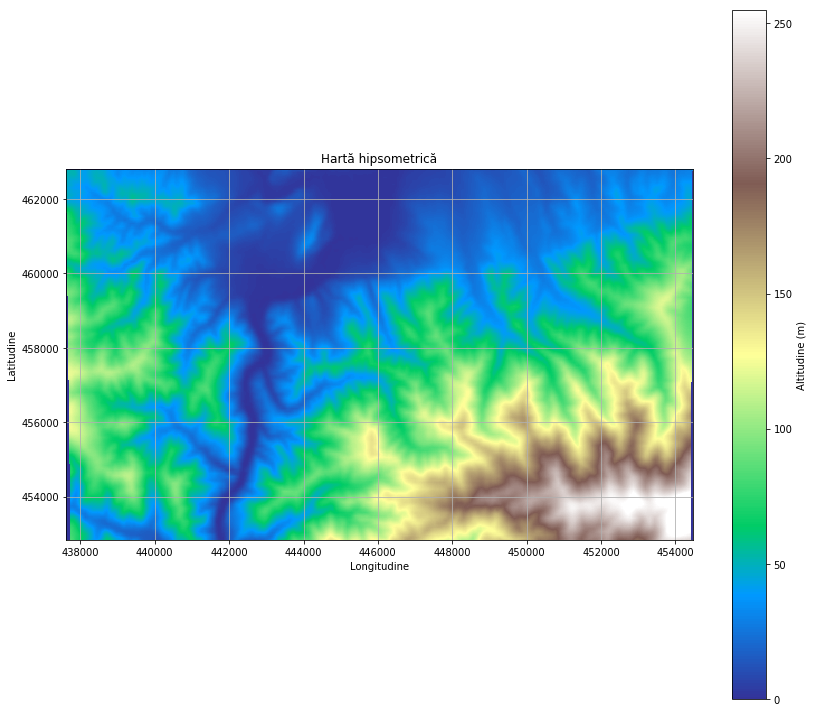

In [73]:
#Plotare si salvare a output-ului

fig, ax = plt.subplots(figsize=(12,10))
fig.patch.set_alpha(0)

plt.imshow(grid.dem, extent=grid.extent, cmap='terrain', zorder=1)
plt.colorbar(label='Altitudine (m)')
plt.grid(zorder=0)
plt.title('Hartă hipsometrică')
plt.xlabel('Longitudine')
plt.ylabel('Latitudine')
plt.tight_layout()
plt.savefig('img/harta_hipsometrica.png', bbox_inches='tight')

In [74]:
#Import Model Numeric al Terenului

grid = Grid.from_raster('.\Raster\Relief.tif', data_name = 'dem')

In [75]:
#Detectare depresiuni

depressions = grid.detect_depressions('dem')

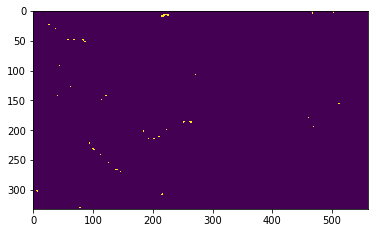

In [76]:
#Plotare output Detectare depresiuni

plt.imshow(depressions)

In [77]:
#Fill depresiuni

grid.fill_depressions(data='dem', out_name='filled_dem')

In [78]:
depressions = grid.detect_depressions('dem')

In [79]:
#Prezenta depresiuni

depressions.any()

True

In [80]:
#Vizualizare suprafete plane

flats = grid.detect_flats('filled_dem')

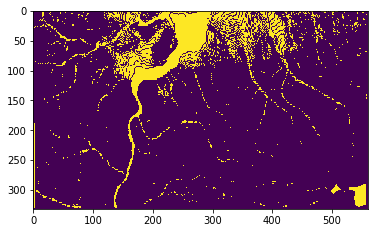

In [81]:
#Output suprafete plane

plt.imshow(flats)

In [82]:
#Eliminare suprafete plane

grid.resolve_flats(data='filled_dem', out_name='noflat_dem')

In [83]:
#Valori directii de curgere
#Nord - 64 / Nord-Est - 128 / Est - 1 / Sud-Est - 2 / Sud - 4 / Sud-Vest - 8 / Vest - 16 / Nord-Vest - 32

dirmap = (64, 128, 1, 2, 4, 8, 16, 32)

In [84]:
#Create Flow Direction

grid.flowdir(data='noflat_dem', out_name='dir', dirmap=dirmap)

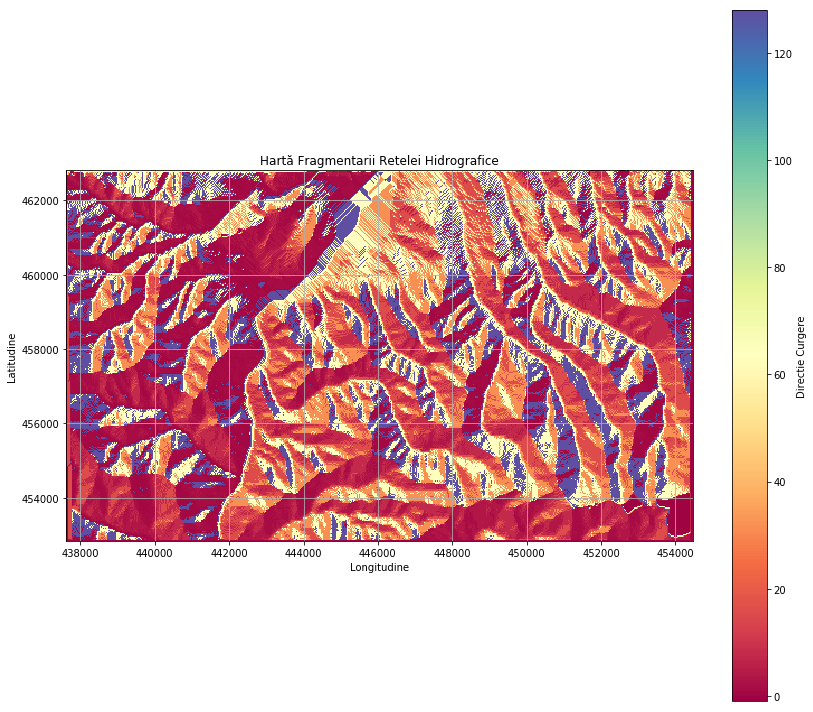

In [85]:
#Plotare si salvare a output-ului

fig, ax = plt.subplots(figsize=(12,10))
fig.patch.set_alpha(0)

plt.imshow(grid.dir, extent=grid.extent, cmap='Spectral', zorder=1)
plt.colorbar(label='Directie Curgere')
plt.grid(zorder=0)
plt.title('Hartă Fragmentarii Retelei Hidrografice')
plt.xlabel('Longitudine')
plt.ylabel('Latitudine')
plt.tight_layout()
plt.savefig('img/harta_fragmentare_retea_hidro.png', bbox_inches='tight')

In [86]:
#Create Flow Accumulation

grid.accumulation(data='dir', out_name='acc', dirmap=dirmap)

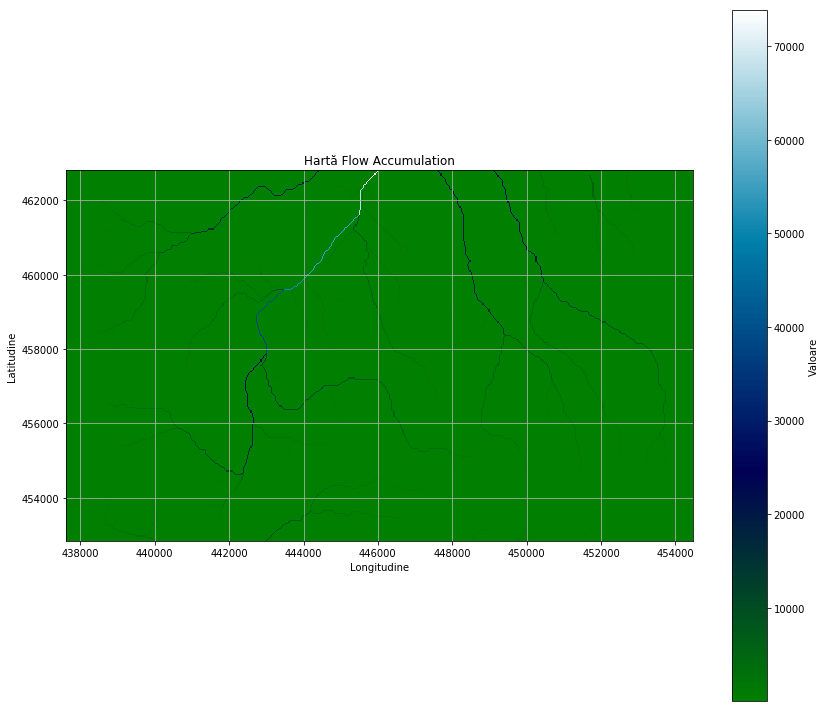

In [87]:
#Plotare si salvare a output-ului

fig, ax = plt.subplots(figsize=(12,10))
fig.patch.set_alpha(0)

plt.imshow(grid.acc, extent=grid.extent, cmap='ocean', zorder=1)
plt.colorbar(label='Valoare')
plt.grid(zorder=0)
plt.title('Hartă Flow Accumulation')
plt.xlabel('Longitudine')
plt.ylabel('Latitudine')
plt.tight_layout()
plt.savefig('img/harta_flow_accumulation.jpg', bbox_inches='tight')

In [88]:
x, y = 442984.176855719, 457402.839013561

In [89]:
#Delimitare Bazin Hidrografic

grid.catchment(data='dir', x=x, y=y, out_name='catch',
                   recursionlimit=15000, xytype='label')

In [90]:
grid.clip_to('catch')

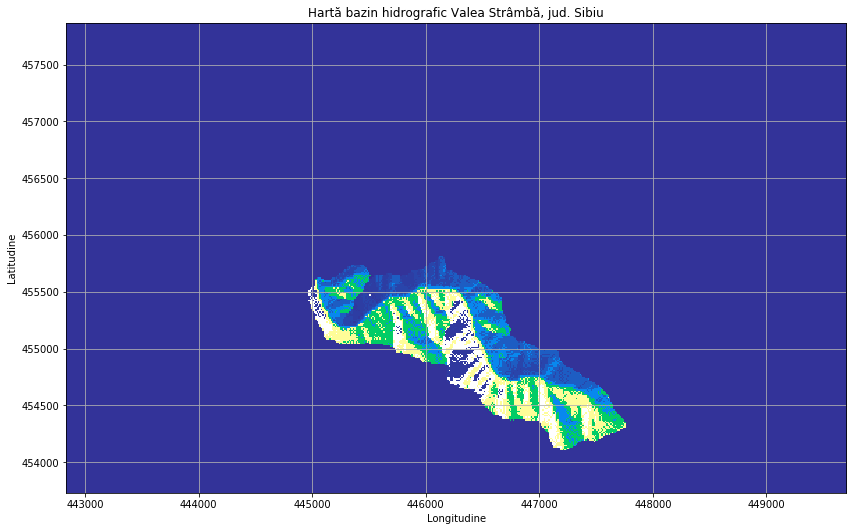

In [91]:
#Plotare si salvare a output-ului

fig, ax = plt.subplots(figsize=(12,10))
fig.patch.set_alpha(0)
plt.imshow(grid.catch, extent=grid.extent, cmap='terrain', zorder=1)
plt.grid(zorder=0)
plt.title('Hartă bazin hidrografic Valea Strâmbă, jud. Sibiu')
plt.xlabel('Longitudine')
plt.ylabel('Latitudine')
plt.tight_layout()
plt.savefig('img/harta_bazin.jpg', bbox_inches='tight')

In [92]:
shapes = grid.polygonize()
shapes = grid.polygonize(grid.mask.astype(np.uint8))

In [93]:
schema = {
    'geometry': 'Polygon',
    'properties': {'LABEL': 'float:16'}
}

with fiona.open('bazin_hidrografic.shp', 'w',
                driver='ESRI Shapefile',
                crs=grid.crs.srs,
                schema=schema) as c:
    i = 0
    for shape, value in shapes:
        rec = {}
        rec['geometry'] = shape
        rec['properties'] = {'LABEL' : str(value)}
        rec['id'] = str(i)
        c.write(rec)
        i += 1

In [94]:
#Distanta Flow

grid.flow_distance(data='catch', x=x, y=y, dirmap=dirmap, out_name='dist',
                   xytype='label', nodata_out=np.nan)

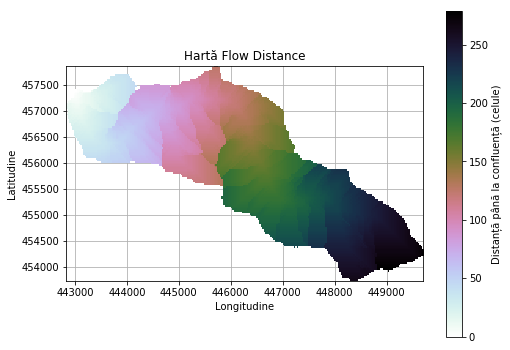

In [95]:
#Plotare si salvare a output-ului

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)
plt.grid('on', zorder=0)
im = ax.imshow(grid.dist, extent=grid.extent, zorder=2,
               cmap='cubehelix_r')
plt.colorbar(im, ax=ax, label='Distanță până la confluență (celule)')
plt.xlabel('Longitudine')
plt.ylabel('Latitudine')
plt.title('Hartă Flow Distance')
plt.savefig('img/harta_flow_distance.png', bbox_inches='tight')

In [96]:
#Extragere retea hidrografica

branches = grid.extract_river_network(fdir='catch', acc='acc',
                                      threshold=50, dirmap=dirmap)

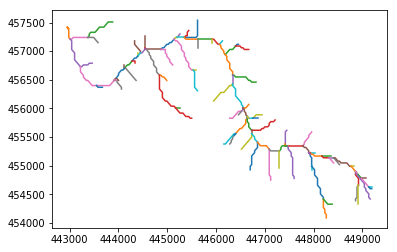

In [97]:
for branch in branches['features']:
    line = np.asarray(branch['geometry']['coordinates'])
    plt.plot(line[:, 0], line[:, 1])

In [62]:
from pysheds.rfsm import RFSM
grid = Grid.from_raster('.\Raster\Relief.tif', data_name='dem')
grid.clip_to('dem')
dem = grid.view('dem')
cell_area = np.abs(grid.affine.a * grid.affine.e)

In [63]:
rfsm = RFSM(dem)

In [64]:
input_vol = 0.1 * cell_area * np.ones(dem.shape)
waterlevel = rfsm.compute_waterlevel(input_vol)

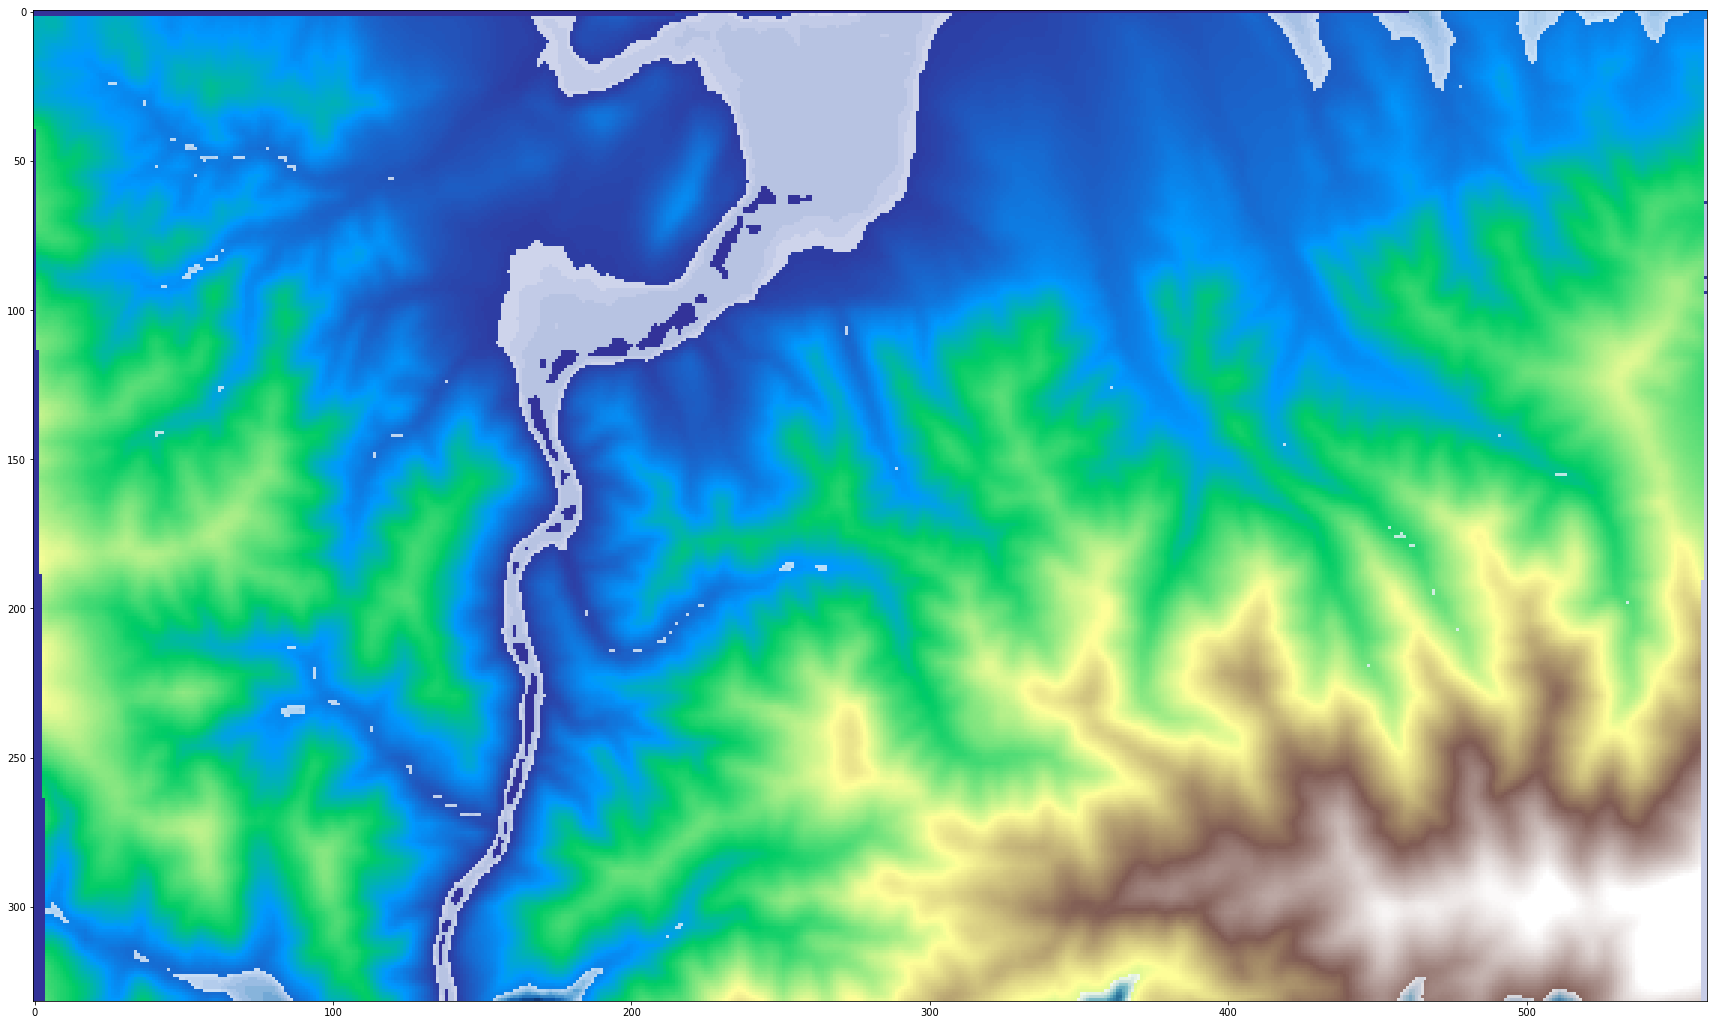

In [65]:
fig = plt.figure(figsize=(30,30))
plt.imshow(np.where(waterlevel, waterlevel - dem, np.nan), zorder=2, cmap='Blues', alpha=0.8)
plt.imshow(dem, zorder=1, cmap='terrain')
plt.savefig('./img/inundatii.png', bbox_inches='tight')

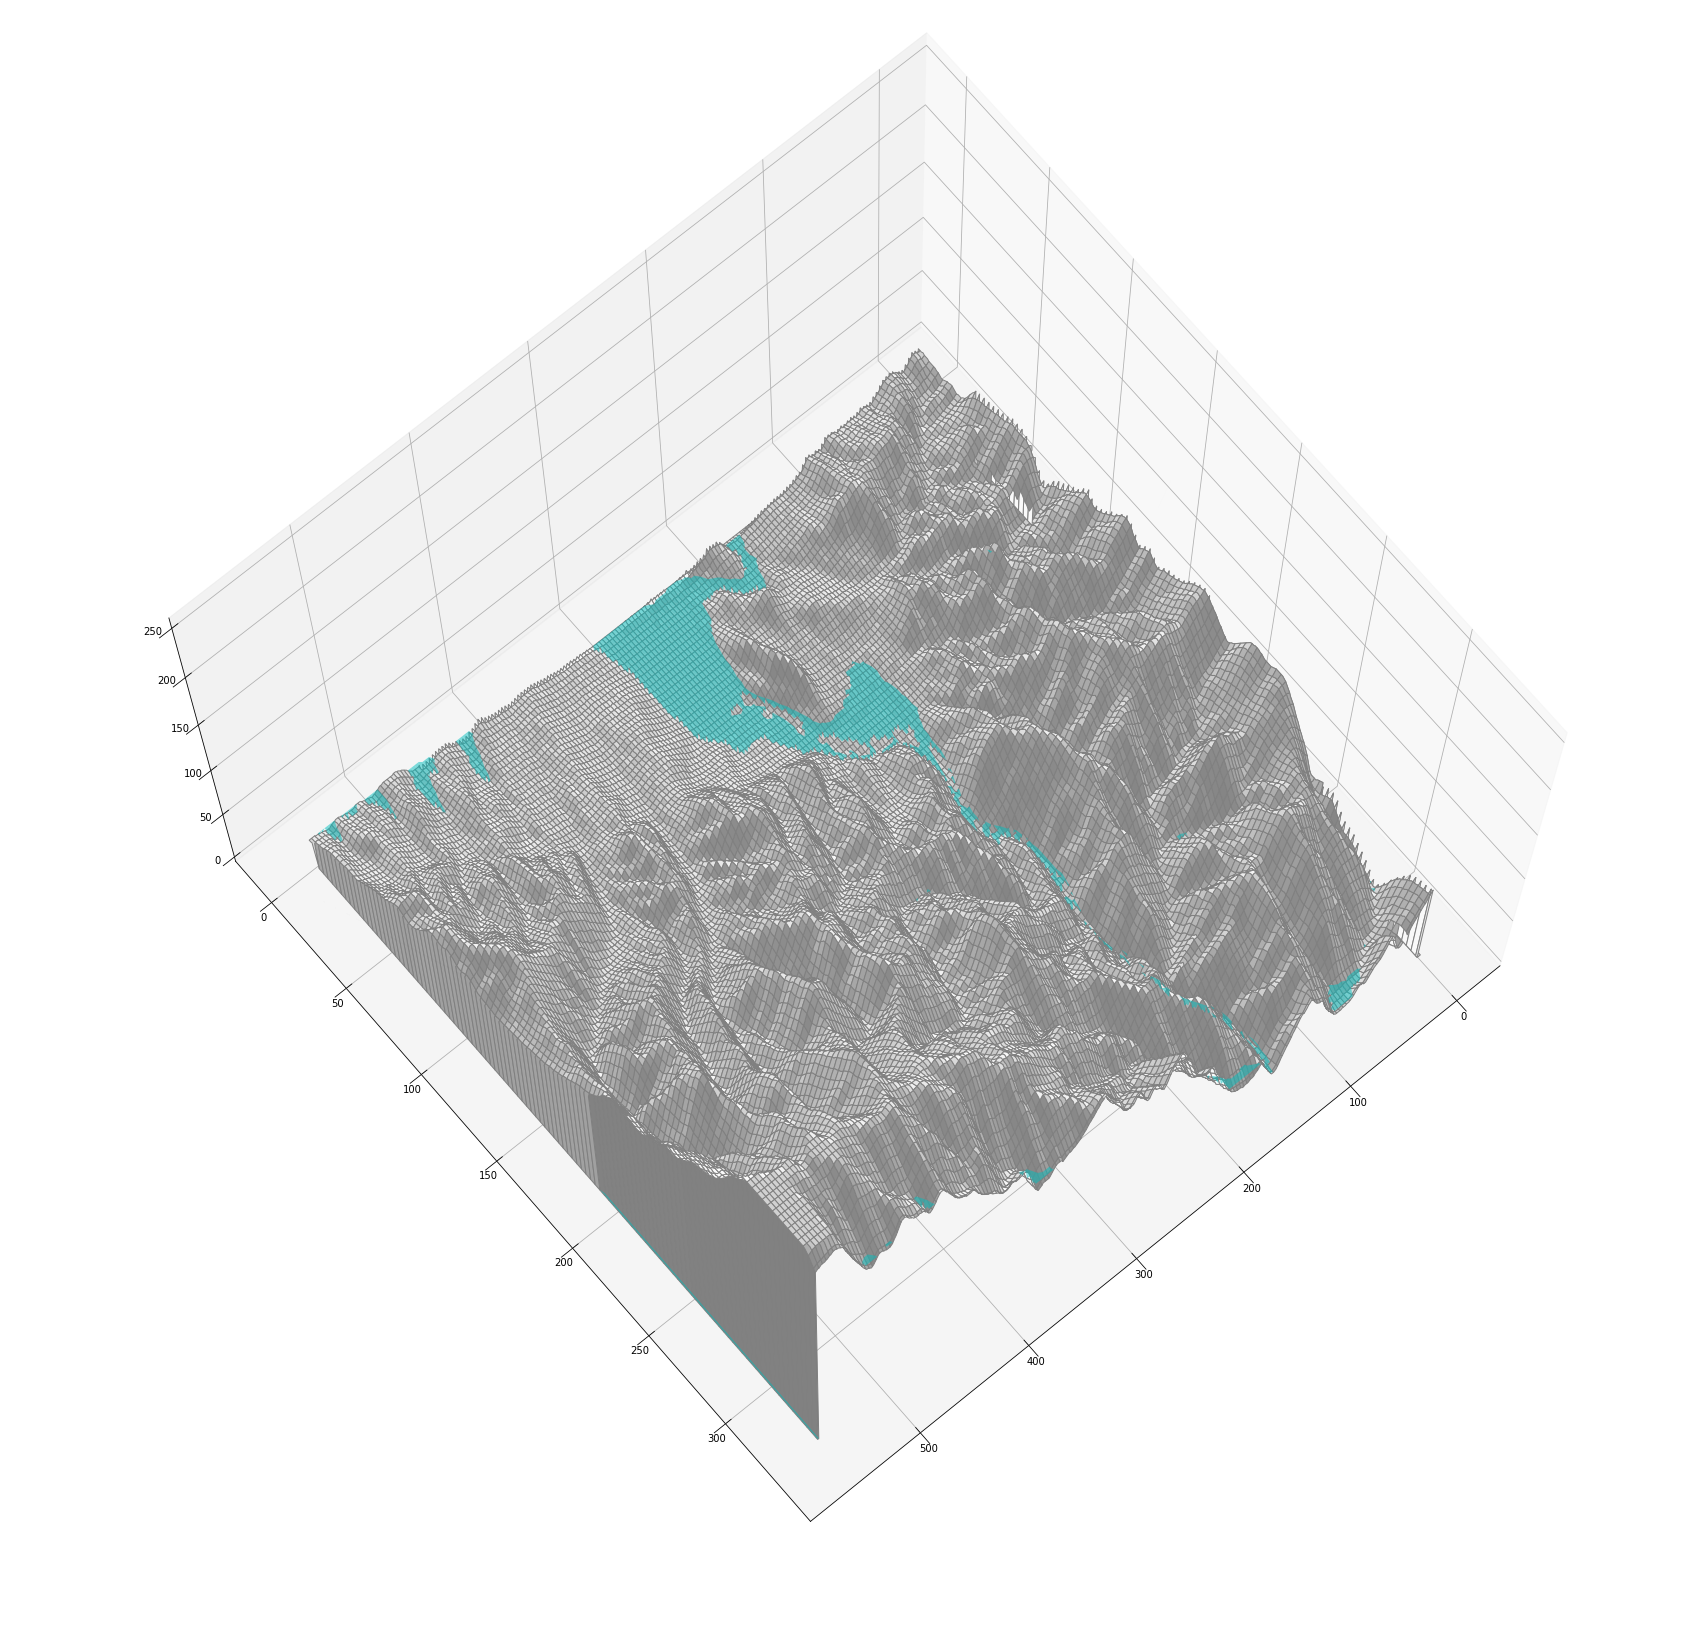

In [30]:

fig = plt.figure(figsize=(30,30))
ax = fig.gca(projection='3d')
plt.gca().patch.set_facecolor('white')

# Make data.
X = np.arange(dem.shape[1])
Y = np.arange(dem.shape[0])
X, Y = np.meshgrid(X, Y)
w = np.where(waterlevel, waterlevel, np.nan)
w.flat[0] = np.nan

# Plot the surface.
surf1 = ax.plot_surface(X, Y, dem, rstride=3, cstride=3, color='0.99', antialiased=True, edgecolor='0.5')
surf2 = ax.plot_surface(X, Y, w, rstride=3, cstride=3, color='c', antialiased=True, alpha=0.5, shade=False)

ax.view_init(75, 50)
plt.savefig('./img/rfsm_3d.png', bbox_inches='tight')